In [1]:
# import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load sota basin shapefile
sota = gpd.read_file('./data/input/sota_basin.shp')

In [3]:
# change projection system of sota to EPSG:4326
sota = sota.to_crs('EPSG:4326')

In [4]:
# load soil data
soil = gpd.read_file('./data/soilmap_benin.shp')

In [5]:
# change projection system of soil to EPSG:4326
soil = soil.to_crs('EPSG:4326')

In [6]:
# extract legend information from avl file
avl_data = [['Rivière', 0, 0],
        ['Sols minéraux bruts', 1, 2],
        ['Sols peu évolués lithiques', 3, 4],
        ['Sols peu évolués modaux', 5, 5],
        ['Sols peu évolués hydromorphes', 6, 9],
        ['Vertisols hydromorphes', 10, 10],
        ['Vertisols modaux', 11, 13],
        ['Sols bruns eutrophes hydromorphes', 14, 14],
        ['Sols bruns eutrophes ferruginisés', 15, 15],
        ['Sols ferrugineux tropicaux peu lessivés, peu lessivés en argile, lessivés en sesquioxydes', 16, 27],
        ['Sols ferrugineux tropicaux peu lessivés hydromorphes', 28, 29],
        ['Sols ferrugineux tropicaux peu lessivés jeunes', 30, 30],
        ['Sols ferrugineux tropicaux lessivés sans concrétions', 31, 44],
        ['Sols ferrugineux tropicaux lessivés à concrétions', 45, 59],
        ['Sols ferrugineux tropicaux lessivés indurés', 60, 72],
        ['Sols ferrugineux tropicaux lessivés hydromorphes', 73, 79],
        ['Sols ferrugineux tropicaux appauvris sans concrétions', 80, 80],
        ['Sols ferrugineux tropicaux appauvris à concrétions', 81, 81],
        ['Sols ferrugineux tropicaux appauvris peu ferruginisés', 82, 82],
        ['Sols ferrallitiques faiblement désaturés appauvris modaux', 83, 87],
        ['Sols ferrallitiques faiblement désaturés appauvris hydromorphes', 88, 88],
        ['Sols ferralitiques faiblement désaturés rajeunis ou pénévolués avec érosion et remaniement', 89, 93],
        ['Sols ferrallitiques moyennement désaturés typiques', 94, 95],
        ['Sols ferrallitiques moyennement désaturés appauvris', 96, 96],
        ['Sols ferrallitiques moyennement désaturés rajeunis ou pénévolués', 97, 97],
        ['Sols hydromorphes moyennement organiques humiques à gley', 98, 99],
        ['Sols hydromorphes minéraux ou peu humifères à gley de profondeur', 100, 102],
        ['Sols hydromorphes  minéraux ou peu humifères à gley lessivés', 103, 104],
        ['Sols hydromorphes minéraux ou peu humifères à pseudo-gley', 105, 107],
        ['No Data', -1, -1]
]
# create avl dataframe
avl = pd.DataFrame(avl_data, columns=['Label', 'MinNum', 'MaxNum'])

In [7]:
# add legend data to soil data for further analysis
df = pd.DataFrame(columns=["SOIL_ID", "label"])
for i, row in avl.iterrows():
    for j in range(row["MinNum"], row["MaxNum"]+1):
        df = df.append({"SOIL_ID": j, "label": row["Label"]}, ignore_index=True)
soil = soil.merge(df, on="SOIL_ID")

In [8]:
# clip soil with sota
soil_sota = gpd.clip(soil, sota)

In [9]:
# show unique values of soil classification in sota
soil_sota['label'].unique()

array(['Rivière', 'Sols minéraux bruts', 'Sols peu évolués lithiques',
       'Sols ferrugineux tropicaux peu lessivés, peu lessivés en argile, lessivés en sesquioxydes',
       'Sols ferrugineux tropicaux peu lessivés hydromorphes',
       'Sols ferrugineux tropicaux lessivés sans concrétions',
       'Sols ferrugineux tropicaux lessivés à concrétions',
       'Sols ferrugineux tropicaux lessivés indurés',
       'Sols ferrugineux tropicaux lessivés hydromorphes',
       'Sols ferralitiques faiblement désaturés rajeunis ou pénévolués avec érosion et remaniement',
       'Sols hydromorphes minéraux ou peu humifères à gley de profondeur'],
      dtype=object)

In [10]:
# group soil types by main categories according to name
sl_conditions = [(soil_sota['label'] == 'Sols ferrugineux tropicaux peu lessivés, peu lessivés en argile, lessivés en sesquioxydes') | (soil_sota['label'] == 'Sols ferrugineux tropicaux peu lessivés hydromorphes') | (soil_sota['label'] == 'Sols ferrugineux tropicaux lessivés sans concrétions') | (soil_sota['label'] == 'Sols ferrugineux tropicaux lessivés indurés') | (soil_sota['label'] == 'Sols ferrugineux tropicaux lessivés hydromorphes') | (soil_sota['label'] == 'Sols ferrugineux tropicaux lessivés à concrétions'),
                 (soil_sota['label'] == 'Sols ferralitiques faiblement désaturés rajeunis ou pénévolués avec érosion et remaniement' ),
                 (soil_sota['label'] == 'Sols hydromorphes minéraux ou peu humifères à gley de profondeur'),
                 (soil_sota['label'] == 'Sols peu évolués lithiques') | (soil_sota['label'] == 'Sols peu évolués modaux') | (soil_sota['label'] == 'Sols peu évolués hydromorphes'),
                 (soil_sota['label'] == 'Sols minéraux bruts'),
                 (soil_sota['label'] == 'Rivière')
                ]
sl_choices = ['ferruginous', 'ferralitic', 'hydromorphic', 'slightly developed', 'vertisols', 'river']
soil_sota['G_Type'] = np.select(sl_conditions, sl_choices, default=None)

In [11]:
# another categorization by sensibility of soils to water
sw_conditions_ = [(soil_sota['G_Type'] == 'hydromorphic') | (soil_sota['G_Type'] == 'river'),       # grey soil, recharges local groundwater flow
                  (soil_sota['G_Type'] == 'vertisols'),         # clay-rich dry soil, expends when wet
                 (soil_sota['G_Type'] == 'ferralitic'),         # red and patchy yellow-red humid tropic soil
                 (soil_sota['G_Type'] == 'slightly developed'), # slightly altered soil, erosive
                 (soil_sota['G_Type'] == 'ferruginous'),        # dark red-brown savanna soil / ultisol
                 ]
sw_choices_ = [5, 4, 3, 2, 1]
soil_sota['W_Type'] = np.select(sw_conditions_, sw_choices_, default=None)

In [12]:
# dissolve soil data with water type column
soil_sota_class = soil_sota.dissolve(by='W_Type').reset_index()

<AxesSubplot:>

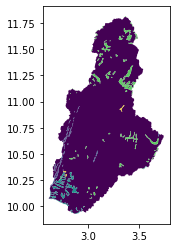

In [13]:
# plot categorized soil
soil_sota_class.plot(column='W_Type')

In [14]:
# export to homogeneous permeability zones of sota
#soil_sota_class.to_file('./data/output/homogeneous_permeability_zone.shp')